### U-net with simple Resnet Blocks v2, can get 0.80+
* Original version : 
  https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks
        
        
#### update log
1.   Cancel last dropout (seems better)
2.  modify convolution_block, to be more consistant with the standard resent model. 
      * https://arxiv.org/abs/1603.05027
3. Use faster  IOU metric score code,
      * https://www.kaggle.com/donchuk/fast-implementation-of-scoring-metric
4. Use  binary_crossentropy loss and then Lovász-hinge loss (very slow!)
     * Lovász-hinge loss: https://github.com/bermanmaxim/LovaszSoftmax
     
Limit the max epochs number to make the kernel finish in the limit of 6 hours, better score can be achived at more epochs 

In [1]:
import os
import sys
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import StratifiedKFold
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

from imgaug import augmenters as iaa
import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

Using TensorFlow backend.


In [2]:
cv_total = 5
version = 8
basic_name = f'Unet_resnet_v{version}'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v8.model
Unet_resnet_v8.csv


In [3]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [4]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("../train/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [5]:
train_df["images"] = [np.array(load_img("../train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

In [6]:
train_df["masks"] = [np.array(load_img("../train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

In [7]:
#### Reference  from Heng's discussion
# https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984#382657
def get_mask_type(mask):
    border = 10
    outer = np.zeros((101-2*border, 101-2*border), np.float32)
    outer = cv2.copyMakeBorder(outer, border, border, border, border, borderType = cv2.BORDER_CONSTANT, value = 1)

    cover = (mask>0.5).sum()
    if cover < 8:
        return 0 # empty
    if cover == ((mask*outer) > 0.5).sum():
        return 1 #border
    if np.all(mask==mask[0]):
        return 2 #vertical

    percentage = cover/(101*101)
    if percentage < 0.15:
        return 3
    elif percentage < 0.25:
        return 4
    elif percentage < 0.50:
        return 5
    elif percentage < 0.75:
        return 6
    else:
        return 7

def histcoverage(coverage):
    histall = np.zeros((1,8))
    for c in coverage:
        histall[0,c] += 1
    return histall

train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_target, 2)

train_df["coverage_class"] = train_df.masks.map(get_mask_type)

In [8]:
train_all = []
evaluate_all = []
skf = StratifiedKFold(n_splits=cv_total, random_state=1234, shuffle=True)
for train_index, evaluate_index in skf.split(train_df.index.values, train_df.coverage_class):
    train_all.append(train_index)
    evaluate_all.append(evaluate_index)
    print(train_index.shape,evaluate_index.shape) # the shape is slightly different in different cv, it's OK

(3198,) (802,)
(3199,) (801,)
(3199,) (801,)
(3200,) (800,)
(3204,) (796,)


In [9]:


def get_cv_data(cv_index):
    train_index = train_all[cv_index-1]
    evaluate_index = evaluate_all[cv_index-1]
    x_train = np.array(train_df.images[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = np.array(train_df.masks[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    x_valid = np.array(train_df.images[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_valid = np.array(train_df.masks[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    return x_train,y_train,x_valid,y_valid



In [10]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x


In [11]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [12]:
def get_iou_vector(A, B):
    A = np.squeeze(A) # new added 
    B = np.squeeze(B) # new added
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
            metric.append(1)
            continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [13]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        #loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        loss = tf.tensordot(tf.nn.elu(errors_sorted)+1, tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [14]:
'''seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            #translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
            rotate=(-10, 10), translate_percent={"x": (-0.05, 0.05)},
                   mode='edge', # rotate by -45 to +45 degrees
            shear=(-10, 10), # shear by -16 to +16 degrees
            order=[1], # use nearest neighbour or bilinear interpolation (fast)
            #cval=0,255, # if mode is constant, use a cval between 0 and 255
            #mode='edge' # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong

        #iaa.ContrastNormalization((0.75, 0.95)), # improve or worsen the contrast
        #iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5),
    ],
    #random_order=True
)

seq_img=seq.to_deterministic()

images_aug_x = seq_img.augment_images(x_train)
images_aug_y =seq_img.augment_images(y_train)
print(x_train.shape)
print(images_aug_x.shape)'''

(3200, 101, 101, 1)
(3200, 101, 101, 1)


In [19]:
 '''affine_seq = iaa.Sequential([
 # General
 iaa.SomeOf((1, 2),
       [iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-10, 10),
                   translate_percent={"x": (-0.05, 0.05)},
                   mode='edge'),
        # iaa.CropAndPad(percent=((0.0, 0.0), (0.05, 0.0), (0.0, 0.0), (0.05, 0.0)))
        ]),
# Deformations
iaa.Sometimes(0.3, iaa.PiecewiseAffine(scale=(0.04, 0.08))),
iaa.Sometimes(0.3, iaa.PerspectiveTransform(scale=(0.05, 0.1))),
], random_order=True)

intensity_seq = iaa.Sequential([
iaa.Invert(0.3),
iaa.Sometimes(0.3, iaa.ContrastNormalization((0.5, 1.5))),
iaa.OneOf([
iaa.Noop(),
iaa.Sequential([
    iaa.OneOf([
        iaa.Add((-10, 10)),
        iaa.AddElementwise((-10, 10)),
        iaa.Multiply((0.95, 1.05)),
        iaa.MultiplyElementwise((0.95, 1.05)),
    ]),
   ]),
  iaa.OneOf([
    iaa.GaussianBlur(sigma=(0.0, 1.0)),
    iaa.AverageBlur(k=(2, 5)),
    iaa.MedianBlur(k=(3, 5))
   ])
])
], random_order=False)



seq_img=affine_seq.to_deterministic()

images_aug_x = seq_img.augment_images(x_train)
images_aug_y =seq_img.augment_images(y_train)
print(x_train.shape)
print(images_aug_y.shape)


seq_img1=intensity_seq.to_deterministic()

images_aug_x1 = seq_img1.augment_images(x_train)
images_aug_y1 =seq_img1.augment_images(y_train)
print(images_aug_x1.shape)'''

(3200, 101, 101, 1)
(3200, 101, 101, 1)
(3200, 101, 101, 1)


In [20]:
'''x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)


print(x_train.shape)
print(y_valid.shape)'''

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [ ]:
'''from imgaug import augmenters as iaa
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from scipy import misc
import imageio 
import numpy as np
from PIL import Image, ImageDraw

seq_img = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10), order=1, mode="constant", cval=0, name="MyAffine")
])

seq_masks = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10), order=0, mode="constant", cval=0, name="MyAffine")
])


img = Image.new('L', [400,400])
d = ImageDraw.Draw(img)
d.rectangle([(150,150),(250,250)], fill=255)

x = img_to_arr

seq_img = seq_img.localize_random_state()

seq_img_i = seq_img.to_deterministic()
seq_masks_i = seq_masks.to_deterministic()

seq_masks_i = seq_masks_i.copy_random_state(seq_img_i, matching="name")
  
imgs_aug = seq_img_i.augment_images(images)
masks_aug = seq_masks_i.augment_images(masks)
'''

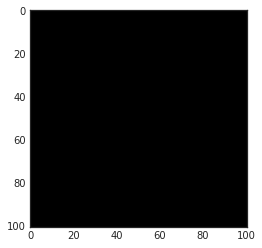

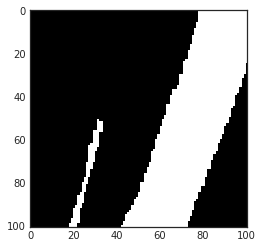

In [23]:
'''ix = random.randint(0, 3200)
plt.imshow(np.dstack((images_aug_x[ix],images_aug_x[ix],images_aug_x[ix])))
plt.show()
tmp = np.squeeze(images_aug_y[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
'''

In [51]:
'''from imgaug import augmenters as iaa
affine_seq = iaa.Sequential([
# General
iaa.SomeOf((1, 2),
           [iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-10, 10),
                       translate_percent={"x": (-0.05, 0.05)},
                       mode='edge'),
            # iaa.CropAndPad(percent=((0.0, 0.0), (0.05, 0.0), (0.0, 0.0), (0.05, 0.0)))
            ]),
# Deformations
iaa.Sometimes(0.3, iaa.PiecewiseAffine(scale=(0.04, 0.08))),
iaa.Sometimes(0.3, iaa.PerspectiveTransform(scale=(0.05, 0.1))),
], random_order=True)

intensity_seq = iaa.Sequential([
iaa.Invert(0.3),
iaa.Sometimes(0.3, iaa.ContrastNormalization((0.5, 1.5))),
iaa.OneOf([
    iaa.Noop(),
    iaa.Sequential([
        iaa.OneOf([
            iaa.Add((-10, 10)),
            iaa.AddElementwise((-10, 10)),
            iaa.Multiply((0.95, 1.05)),
            iaa.MultiplyElementwise((0.95, 1.05)l),
        ]),
    ]),
    iaa.OneOf([
        iaa.GaussianBlur(sigma=(0.0, 1.0)),
        iaa.AverageBlur(k=(2, 5)),
        iaa.MedianBlur(k=(3, 5))
    ])
])
], random_order=False)'''

'from imgaug import augmenters as iaa\naffine_seq = iaa.Sequential([\n# General\niaa.SomeOf((1, 2),\n           [iaa.Fliplr(0.5),\n            iaa.Affine(rotate=(-10, 10),\n                       translate_percent={"x": (-0.05, 0.05)},\n                       mode=\'edge\'),\n            # iaa.CropAndPad(percent=((0.0, 0.0), (0.05, 0.0), (0.0, 0.0), (0.05, 0.0)))\n            ]),\n# Deformations\niaa.Sometimes(0.3, iaa.PiecewiseAffine(scale=(0.04, 0.08))),\niaa.Sometimes(0.3, iaa.PerspectiveTransform(scale=(0.05, 0.1))),\n], random_order=True)\n\nintensity_seq = iaa.Sequential([\niaa.Invert(0.3),\niaa.Sometimes(0.3, iaa.ContrastNormalization((0.5, 1.5))),\niaa.OneOf([\n    iaa.Noop(),\n    iaa.Sequential([\n        iaa.OneOf([\n            iaa.Add((-10, 10)),\n            iaa.AddElementwise((-10, 10)),\n            iaa.Multiply((0.95, 1.05)),\n            iaa.MultiplyElementwise((0.95, 1.05)l),\n        ]),\n    ]),\n    iaa.OneOf([\n        iaa.GaussianBlur(sigma=(0.0, 1.0)),\n       

In [14]:
'''# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.001)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

#model1.summary()'''

In [ ]:
'''early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=50, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
#reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.5, patience=6, min_lr=0.00001, verbose=1)

epochs = 300
batch_size = 32
history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,early_stopping], 
                    verbose=1)'''

Train on 6400 samples, validate on 800 samples
Epoch 1/300
6400/6400 [==============================] - 23s 4ms/step - loss: 0.4333 - my_iou_metric: 0.3243 - val_loss: 0.7301 - val_my_iou_metric: 0.3563

Epoch 00001: val_my_iou_metric improved from -inf to 0.35625, saving model to Unet_resnet_v8.model
Epoch 2/300
6400/6400 [==============================] - 24s 4ms/step - loss: 0.3043 - my_iou_metric: 0.4770 - val_loss: 0.3394 - val_my_iou_metric: 0.5196

Epoch 00002: val_my_iou_metric improved from 0.35625 to 0.51963, saving model to Unet_resnet_v8.model
Epoch 3/300
6400/6400 [==============================] - 18s 3ms/step - loss: 0.2646 - my_iou_metric: 0.5309 - val_loss: 0.2693 - val_my_iou_metric: 0.5212

Epoch 00003: val_my_iou_metric improved from 0.51963 to 0.52125, saving model to Unet_resnet_v8.model
Epoch 4/300
6400/6400 [==============================] - 35s 5ms/step - loss: 0.2368 - my_iou_metric: 0.5684 - val_loss: 0.2499 - val_my_iou_metric: 0.6079

Epoch 00004: val_my_io

6400/6400 [==============================] - 51s 8ms/step - loss: 0.1103 - my_iou_metric: 0.7554 - val_loss: 0.1442 - val_my_iou_metric: 0.7478

Epoch 00036: val_my_iou_metric did not improve from 0.76200
Epoch 37/300
6400/6400 [==============================] - -5s -779us/step - loss: 0.1093 - my_iou_metric: 0.7583 - val_loss: 0.1372 - val_my_iou_metric: 0.7423

Epoch 00037: val_my_iou_metric did not improve from 0.76200
Epoch 38/300
6400/6400 [==============================] - 15s 2ms/step - loss: 0.1110 - my_iou_metric: 0.7560 - val_loss: 0.1301 - val_my_iou_metric: 0.7514

Epoch 00038: val_my_iou_metric did not improve from 0.76200
Epoch 39/300
6400/6400 [==============================] - 32s 5ms/step - loss: 0.1066 - my_iou_metric: 0.7621 - val_loss: 0.1451 - val_my_iou_metric: 0.7281

Epoch 00039: val_my_iou_metric did not improve from 0.76200
Epoch 40/300
6400/6400 [==============================] - 14s 2ms/step - loss: 0.1076 - my_iou_metric: 0.7552 - val_loss: 0.1635 - val_my_

Epoch 73/300
6400/6400 [==============================] - 37s 6ms/step - loss: 0.0749 - my_iou_metric: 0.7985 - val_loss: 0.1393 - val_my_iou_metric: 0.7689

Epoch 00073: val_my_iou_metric did not improve from 0.78588
Epoch 74/300
6400/6400 [==============================] - 10s 2ms/step - loss: 0.0720 - my_iou_metric: 0.7948 - val_loss: 0.1481 - val_my_iou_metric: 0.7864

Epoch 00074: val_my_iou_metric improved from 0.78588 to 0.78638, saving model to Unet_resnet_v8.model
Epoch 75/300
6400/6400 [==============================] - 13s 2ms/step - loss: 0.0711 - my_iou_metric: 0.7956 - val_loss: 0.1421 - val_my_iou_metric: 0.7590

Epoch 00075: val_my_iou_metric did not improve from 0.78638
Epoch 76/300
6400/6400 [==============================] - 36s 6ms/step - loss: 0.0754 - my_iou_metric: 0.7940 - val_loss: 0.1686 - val_my_iou_metric: 0.7571

Epoch 00076: val_my_iou_metric did not improve from 0.78638
Epoch 77/300
6400/6400 [==============================] - 11s 2ms/step - loss: 0.0690 

6400/6400 [==============================] - 17s 3ms/step - loss: 0.0586 - my_iou_metric: 0.8181 - val_loss: 0.1670 - val_my_iou_metric: 0.7661

Epoch 00127: val_my_iou_metric did not improve from 0.79238
Epoch 128/300
6400/6400 [==============================] - 22s 3ms/step - loss: 0.0483 - my_iou_metric: 0.8248 - val_loss: 0.1779 - val_my_iou_metric: 0.7792

Epoch 00128: val_my_iou_metric did not improve from 0.79238
Epoch 129/300
6400/6400 [==============================] - 21s 3ms/step - loss: 0.0467 - my_iou_metric: 0.8302 - val_loss: 0.1831 - val_my_iou_metric: 0.7840

Epoch 00129: val_my_iou_metric did not improve from 0.79238
Epoch 130/300
6400/6400 [==============================] - 19s 3ms/step - loss: 0.0464 - my_iou_metric: 0.8320 - val_loss: 0.2115 - val_my_iou_metric: 0.7494

Epoch 00130: val_my_iou_metric did not improve from 0.79238
Epoch 131/300
6400/6400 [==============================] - 29s 5ms/step - loss: 0.0508 - my_iou_metric: 0.8221 - val_loss: 0.2434 - val_my

6400/6400 [==============================] - 19s 3ms/step - loss: 0.0471 - my_iou_metric: 0.8297 - val_loss: 0.2029 - val_my_iou_metric: 0.7405

Epoch 00201: val_my_iou_metric did not improve from 0.80150
Epoch 202/300
6400/6400 [==============================] - 29s 5ms/step - loss: 0.0359 - my_iou_metric: 0.8487 - val_loss: 0.1557 - val_my_iou_metric: 0.7777

Epoch 00202: val_my_iou_metric did not improve from 0.80150
Epoch 203/300
6400/6400 [==============================] - 14s 2ms/step - loss: 0.0332 - my_iou_metric: 0.8547 - val_loss: 0.1642 - val_my_iou_metric: 0.7840

Epoch 00203: val_my_iou_metric did not improve from 0.80150
Epoch 204/300
6400/6400 [==============================] - 41s 6ms/step - loss: 0.0313 - my_iou_metric: 0.8596 - val_loss: 0.1792 - val_my_iou_metric: 0.7766

Epoch 00204: val_my_iou_metric did not improve from 0.80150
Epoch 205/300
6400/6400 [==============================] - 6s 903us/step - loss: 0.0338 - my_iou_metric: 0.8579 - val_loss: 0.1794 - val_m

In [16]:
'''model1 = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric})
# remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input

output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr = 0.0005)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

#model.summary()'''

In [18]:
'''model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})
c = optimizers.adam(lr = 0.0001)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])'''

In [19]:
'''early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=40, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
#reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=6, min_lr=0.00001, verbose=1)
epochs = 100
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,early_stopping], 
                    verbose=1)'''

Train on 6400 samples, validate on 800 samples
Epoch 1/100
6400/6400 [==============================] - 96s 15ms/step - loss: 0.4299 - my_iou_metric_2: 0.8851 - val_loss: 1.0075 - val_my_iou_metric_2: 0.8125

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.81250, saving model to Unet_resnet_v8.model
Epoch 2/100
6400/6400 [==============================] - 73s 11ms/step - loss: 0.4222 - my_iou_metric_2: 0.8897 - val_loss: 1.0250 - val_my_iou_metric_2: 0.8105

Epoch 00002: val_my_iou_metric_2 did not improve from 0.81250
Epoch 3/100
6400/6400 [==============================] - 76s 12ms/step - loss: 0.4132 - my_iou_metric_2: 0.8888 - val_loss: 0.9945 - val_my_iou_metric_2: 0.8147

Epoch 00003: val_my_iou_metric_2 improved from 0.81250 to 0.81475, saving model to Unet_resnet_v8.model
Epoch 4/100
6400/6400 [==============================] - 75s 12ms/step - loss: 0.4127 - my_iou_metric_2: 0.8907 - val_loss: 1.0096 - val_my_iou_metric_2: 0.8113

Epoch 00004: val_my_iou_metric_2 did n

KeyboardInterrupt: 

In [14]:
def build_complie_model(lr = 0.01):
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = build_model(input_layer, 16,0.5)

    model1 = Model(input_layer, output_layer)

    c = optimizers.adam(lr = lr)
    model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])
    return model1


In [19]:
def build_complie_model1(lr, save_model_name):
    model1 = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})
    c = optimizers.adam(lr = 0.0001)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
    model1.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])
    return model1

In [1]:
def build_complie_model(lr, save_model_name):
    model2=load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric})
    input_layer = model2.layers[0].input
    output_layer = model2.layers[-1].input

    model1 = Model(input_layer, output_layer)

    c = optimizers.adam(lr = lr)
    model1.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])
    return model1

In [17]:
def plot_history(history,metric_name):
    fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_score.plot(history.epoch, history.history[metric_name], label="Train score")
    ax_score.plot(history.epoch, history.history["val_" + metric_name], label="Validation score")
    ax_score.legend()

def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

############################################
 Unet_resnet_v8_cv1
Train on 6396 samples, validate on 802 samples
Epoch 1/60
 - 84s - loss: 0.5901 - my_iou_metric_2: 0.8695 - val_loss: 1.1657 - val_my_iou_metric_2: 0.7909

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.79090, saving model to Unet_resnet_v8_cv1.model
Epoch 2/60
 - 62s - loss: 0.5810 - my_iou_metric_2: 0.8691 - val_loss: 1.1630 - val_my_iou_metric_2: 0.7920

Epoch 00002: val_my_iou_metric_2 improved from 0.79090 to 0.79202, saving model to Unet_resnet_v8_cv1.model
Epoch 3/60
 - 66s - loss: 0.5797 - my_iou_metric_2: 0.8733 - val_loss: 1.1638 - val_my_iou_metric_2: 0.7919

Epoch 00003: val_my_iou_metric_2 did not improve from 0.79202
Epoch 4/60
 - 68s - loss: 0.5753 - my_iou_metric_2: 0.8712 - val_loss: 1.1592 - val_my_iou_metric_2: 0.7916

Epoch 00004: val_my_iou_metric_2 did not improve from 0.79202
Epoch 5/60
 - 68s - loss: 0.5741 - my_iou_metric_2: 0.8717 - val_loss: 1.1596 - val_my_iou_metric_2: 0.7928

Epoch 


Epoch 00045: val_my_iou_metric_2 did not improve from 0.79701
Epoch 46/60
 - 63s - loss: 0.5261 - my_iou_metric_2: 0.8753 - val_loss: 1.1105 - val_my_iou_metric_2: 0.7955

Epoch 00046: val_my_iou_metric_2 did not improve from 0.79701
Epoch 47/60
 - 70s - loss: 0.5250 - my_iou_metric_2: 0.8754 - val_loss: 1.1100 - val_my_iou_metric_2: 0.7968

Epoch 00047: val_my_iou_metric_2 did not improve from 0.79701
Epoch 48/60
 - 70s - loss: 0.5184 - my_iou_metric_2: 0.8759 - val_loss: 1.1056 - val_my_iou_metric_2: 0.7930

Epoch 00048: val_my_iou_metric_2 did not improve from 0.79701
Epoch 49/60
 - 61s - loss: 0.5264 - my_iou_metric_2: 0.8756 - val_loss: 1.1042 - val_my_iou_metric_2: 0.7956

Epoch 00049: val_my_iou_metric_2 did not improve from 0.79701
Epoch 50/60
 - 76s - loss: 0.5224 - my_iou_metric_2: 0.8753 - val_loss: 1.1013 - val_my_iou_metric_2: 0.7948

Epoch 00050: val_my_iou_metric_2 did not improve from 0.79701
Epoch 51/60
 - 73s - loss: 0.5293 - my_iou_metric_2: 0.8733 - val_loss: 1.095


Epoch 00030: val_my_iou_metric_2 did not improve from 0.79463
Epoch 31/60
 - 68s - loss: 0.6116 - my_iou_metric_2: 0.8618 - val_loss: 1.0245 - val_my_iou_metric_2: 0.7944

Epoch 00031: val_my_iou_metric_2 did not improve from 0.79463
Epoch 32/60
 - 68s - loss: 0.6002 - my_iou_metric_2: 0.8631 - val_loss: 1.0228 - val_my_iou_metric_2: 0.7938

Epoch 00032: val_my_iou_metric_2 did not improve from 0.79463
Epoch 33/60
 - 69s - loss: 0.6002 - my_iou_metric_2: 0.8632 - val_loss: 1.0233 - val_my_iou_metric_2: 0.7948

Epoch 00033: val_my_iou_metric_2 improved from 0.79463 to 0.79476, saving model to Unet_resnet_v8_cv2.model
Epoch 34/60
 - 69s - loss: 0.6051 - my_iou_metric_2: 0.8634 - val_loss: 1.0199 - val_my_iou_metric_2: 0.7935

Epoch 00034: val_my_iou_metric_2 did not improve from 0.79476
Epoch 35/60
 - 70s - loss: 0.6037 - my_iou_metric_2: 0.8641 - val_loss: 1.0184 - val_my_iou_metric_2: 0.7949

Epoch 00035: val_my_iou_metric_2 improved from 0.79476 to 0.79488, saving model to Unet_resne

 - 46s - loss: 0.5503 - my_iou_metric_2: 0.8761 - val_loss: 1.2036 - val_my_iou_metric_2: 0.7831

Epoch 00016: val_my_iou_metric_2 did not improve from 0.78589
Epoch 17/60
 - 68s - loss: 0.5435 - my_iou_metric_2: 0.8740 - val_loss: 1.1990 - val_my_iou_metric_2: 0.7828

Epoch 00017: val_my_iou_metric_2 did not improve from 0.78589
Epoch 18/60
 - 68s - loss: 0.5350 - my_iou_metric_2: 0.8779 - val_loss: 1.2052 - val_my_iou_metric_2: 0.7838

Epoch 00018: val_my_iou_metric_2 did not improve from 0.78589
Epoch 19/60
 - 68s - loss: 0.5375 - my_iou_metric_2: 0.8765 - val_loss: 1.1974 - val_my_iou_metric_2: 0.7828

Epoch 00019: val_my_iou_metric_2 did not improve from 0.78589
Epoch 20/60
 - 69s - loss: 0.5398 - my_iou_metric_2: 0.8770 - val_loss: 1.1965 - val_my_iou_metric_2: 0.7851

Epoch 00020: val_my_iou_metric_2 did not improve from 0.78589
Epoch 21/60
 - 70s - loss: 0.5348 - my_iou_metric_2: 0.8781 - val_loss: 1.1937 - val_my_iou_metric_2: 0.7809

Epoch 00021: val_my_iou_metric_2 did not i


Epoch 00002: val_my_iou_metric_2 improved from 0.78638 to 0.78838, saving model to Unet_resnet_v8_cv4.model
Epoch 3/60
 - 64s - loss: 0.5917 - my_iou_metric_2: 0.8748 - val_loss: 1.1651 - val_my_iou_metric_2: 0.7881

Epoch 00003: val_my_iou_metric_2 did not improve from 0.78838
Epoch 4/60
 - 69s - loss: 0.5856 - my_iou_metric_2: 0.8755 - val_loss: 1.1587 - val_my_iou_metric_2: 0.7906

Epoch 00004: val_my_iou_metric_2 improved from 0.78838 to 0.79063, saving model to Unet_resnet_v8_cv4.model
Epoch 5/60
 - 62s - loss: 0.5844 - my_iou_metric_2: 0.8763 - val_loss: 1.1529 - val_my_iou_metric_2: 0.7907

Epoch 00005: val_my_iou_metric_2 improved from 0.79063 to 0.79075, saving model to Unet_resnet_v8_cv4.model
Epoch 6/60
 - 75s - loss: 0.5777 - my_iou_metric_2: 0.8783 - val_loss: 1.1509 - val_my_iou_metric_2: 0.7914

Epoch 00006: val_my_iou_metric_2 improved from 0.79075 to 0.79138, saving model to Unet_resnet_v8_cv4.model
Epoch 7/60
 - 78s - loss: 0.5617 - my_iou_metric_2: 0.8780 - val_loss


Epoch 00048: val_my_iou_metric_2 did not improve from 0.79575
Epoch 49/60
 - 69s - loss: 0.5018 - my_iou_metric_2: 0.8827 - val_loss: 1.0685 - val_my_iou_metric_2: 0.7940

Epoch 00049: val_my_iou_metric_2 did not improve from 0.79575
Epoch 50/60
 - 69s - loss: 0.5042 - my_iou_metric_2: 0.8816 - val_loss: 1.0696 - val_my_iou_metric_2: 0.7961

Epoch 00050: val_my_iou_metric_2 improved from 0.79575 to 0.79612, saving model to Unet_resnet_v8_cv4.model
Epoch 51/60
 - 70s - loss: 0.5016 - my_iou_metric_2: 0.8831 - val_loss: 1.0664 - val_my_iou_metric_2: 0.7958

Epoch 00051: val_my_iou_metric_2 did not improve from 0.79612
Epoch 52/60
 - 71s - loss: 0.4970 - my_iou_metric_2: 0.8831 - val_loss: 1.0703 - val_my_iou_metric_2: 0.7971

Epoch 00052: val_my_iou_metric_2 improved from 0.79612 to 0.79712, saving model to Unet_resnet_v8_cv4.model
Epoch 53/60
 - 72s - loss: 0.4972 - my_iou_metric_2: 0.8841 - val_loss: 1.0681 - val_my_iou_metric_2: 0.7963

Epoch 00053: val_my_iou_metric_2 did not improv


Epoch 00034: val_my_iou_metric_2 improved from 0.81093 to 0.81131, saving model to Unet_resnet_v8_cv5.model
Epoch 35/60
 - 69s - loss: 0.6808 - my_iou_metric_2: 0.8432 - val_loss: 0.8618 - val_my_iou_metric_2: 0.8114

Epoch 00035: val_my_iou_metric_2 improved from 0.81131 to 0.81143, saving model to Unet_resnet_v8_cv5.model
Epoch 36/60
 - 70s - loss: 0.6733 - my_iou_metric_2: 0.8430 - val_loss: 0.8598 - val_my_iou_metric_2: 0.8104

Epoch 00036: val_my_iou_metric_2 did not improve from 0.81143
Epoch 37/60
 - 71s - loss: 0.6813 - my_iou_metric_2: 0.8434 - val_loss: 0.8601 - val_my_iou_metric_2: 0.8119

Epoch 00037: val_my_iou_metric_2 improved from 0.81143 to 0.81193, saving model to Unet_resnet_v8_cv5.model
Epoch 38/60
 - 73s - loss: 0.6735 - my_iou_metric_2: 0.8423 - val_loss: 0.8602 - val_my_iou_metric_2: 0.8126

Epoch 00038: val_my_iou_metric_2 improved from 0.81193 to 0.81256, saving model to Unet_resnet_v8_cv5.model
Epoch 39/60
 - 70s - loss: 0.6777 - my_iou_metric_2: 0.8430 - val

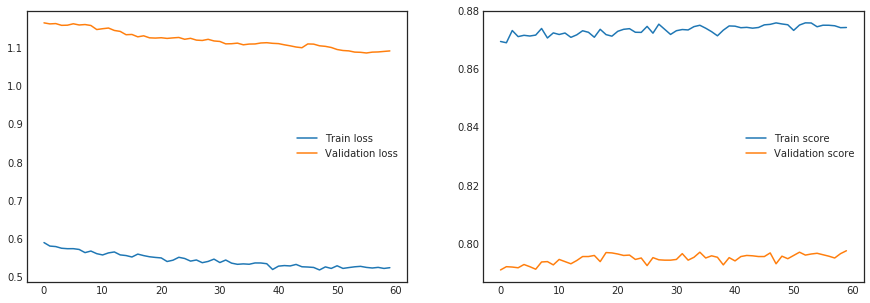

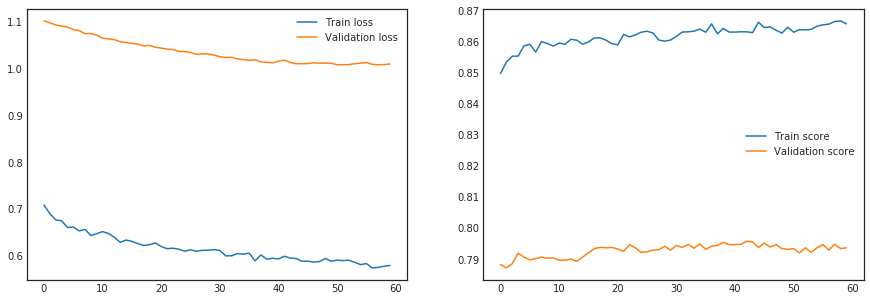

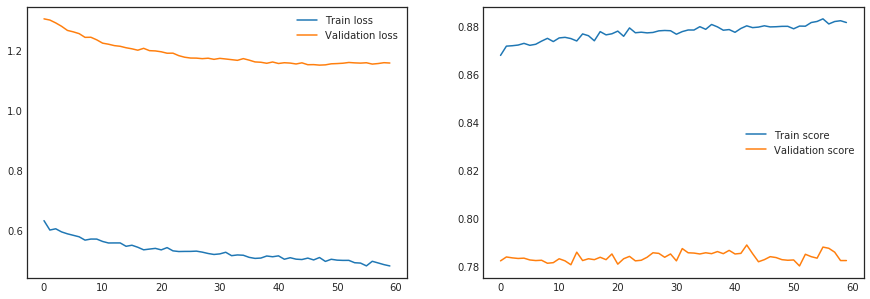

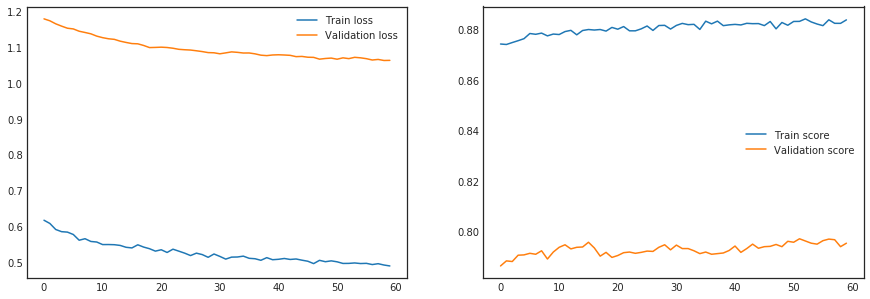

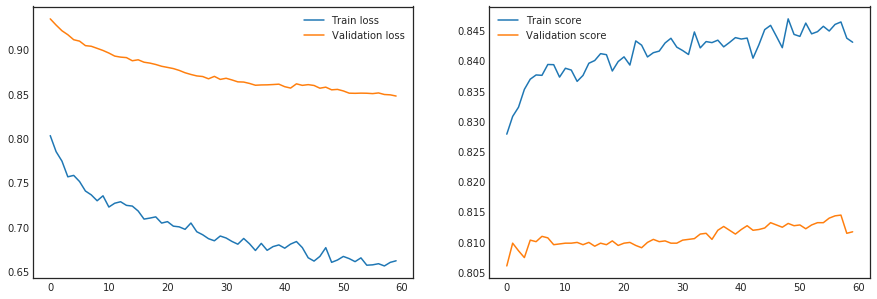

In [20]:
# training
ious = [0] * cv_total

cv_index=0
basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
print('############################################\n', basic_name)
save_model_name = basic_name + '.model'

x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)

#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
lr = 0.01
model = build_complie_model1(lr,save_model_name)

model_checkpoint = ModelCheckpoint(save_model_name,monitor='my_iou_metric', 
                               mode = 'max', save_best_only=True, verbose=1)
#reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',
 #                             factor=0.5, patience=20, min_lr=0.0001, verbose=1)

epochs = 60 #small number for demonstration 
batch_size = 64
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint], 
                    verbose=2)
plot_history(history,'my_iou_metric_2')

model.load_weights(save_model_name)

preds_valid = predict_result(model,x_valid,img_size_target)
ious[cv_index] = get_iou_vector(y_valid, (preds_valid > 0))


for cv_index in range(1,cv_total):
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    print('############################################\n', basic_name)
    save_model_name = basic_name + '.model'
    
    x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)
    
    #Data augmentation
    x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
    lr = 0.0001
    model = build_complie_model(lr,save_model_name)

    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
    #reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',
     #                             factor=0.5, patience=20, min_lr=0.0001, verbose=1)

    epochs = 60 #small number for demonstration 
    batch_size = 64
    history = model.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[ model_checkpoint], 
                        verbose=2)
    plot_history(history,'my_iou_metric_2')
    
    model.load_weights(save_model_name)
    
    preds_valid = predict_result(model,x_valid,img_size_target)
    ious[cv_index] = get_iou_vector(y_valid, (preds_valid > 0))
    
#model1.summary()

In [21]:


for cv_index in range(cv_total):
    print(f"cv {cv_index} ious = {ious[cv_index]}")



cv 0 ious = 0.8037406483790523
cv 1 ious = 0.8013732833957554
cv 2 ious = 0.7891385767790262
cv 3 ious = 0.80475
cv 4 ious = 0.820854271356784


In [24]:
#preds_valid = predict_result(model,x_valid,img_size_target)

In [26]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

A Jupyter Widget


[0.81375  0.815    0.814875 0.814    0.814    0.8145   0.814625 0.814625
 0.81625  0.816625 0.8165   0.81625  0.81575  0.81575  0.81575  0.81575
 0.81575  0.81575  0.815625 0.814875 0.81475  0.814625 0.814375 0.81425
 0.814125 0.81425  0.814    0.813875 0.81375  0.81325  0.812875]


In [22]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [23]:
x_test = np.array([(np.array(load_img("../test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)



/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/infor/anaconda/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "graysc

In [24]:
# average the predictions from different folds
t1 = time.time()
preds_test = np.zeros(np.squeeze(x_test).shape)
for cv_index in range(cv_total):
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    model.load_weights(basic_name + '.model')
    preds_test += predict_result(model,x_test,img_size_target) /cv_total
    
t2 = time.time()
print(f"Usedtime = {t2-t1} s")

Usedtime = 226.2351531982422 s


In [25]:


t1 = time.time()
threshold  = 0 # some value in range 0.4- 0.5 may be better 
pred_dict = {idx: rle_encode(np.round(preds_test[i]) > threshold) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")




Usedtime = 1.5360960960388184 s


In [26]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv("thresh0.csv")

In [27]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 5.980398666792445 hours


In [28]:
threshold  = -0.05 # some value in range 0.4- 0.5 may be better 
pred_dict = {idx: rle_encode(np.round(preds_test[i]) > threshold) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}


In [29]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv("thresh05.csv")